# 批量规范化

从零实现

In [1]:
import sys
sys.path.append('..')

In [ ]:
from d2l import mindspore as d2l
import mindspore as ms
from mindspore import nn, mint, Parameter
import mindspore.ops as ops 

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum, training):
    if not training:
        X_hat = (X - moving_mean) / mint.sqrt(moving_var + eps)
    else:
        if len(X.shape) == 2:
            mean = mint.mean(X, dim=0)
            var = mint.mean(((X - mean) ** 2), dim=0)
        else:
            mean = mint.mean(X, dim=(0, 2, 3), keepdim=True)
            var = mint.mean(((X - mean) ** 2), dim=(0, 2, 3), keepdim=True)
        
        X_hat = (X - mean) / mint.sqrt(var + eps)       
        
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
        
    Y = gamma * X_hat + beta
    return Y, moving_mean, moving_var

创建一个正确的`BatchNorm`图层

In [3]:
class BatchNorm(nn.Cell):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = Parameter(mint.ones(shape))
        self.beta = Parameter(mint.zeros(shape))
        self.moving_mean = Parameter(mint.zeros(shape), requires_grad=False)
        self.moving_var = Parameter(mint.ones(shape), requires_grad=False)
        self.assign = ops.Assign()
        
    def construct(self, X):
        Y, moving_mean, moving_var = batch_norm(X, self.gamma, self.beta, self.moving_mean,
                                                self.moving_var, 1e-5, 0.9, self.training)
        self.assign(self.moving_mean, moving_mean)
        self.assign(self.moving_var, moving_var)
        return Y

应用`BatchNorm`
于LeNet模型

In [4]:
net = nn.SequentialCell([
        nn.Conv2d(1, 6, kernel_size=5, pad_mode='pad'), BatchNorm(6, num_dims=4), nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5, pad_mode='pad'), BatchNorm(16, num_dims=4), nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
        nn.Dense(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
        nn.Dense(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
        nn.Dense(84, 10)])

在Fashion-MNIST数据集上训练网络

loss 0.254, train acc 0.907, test acc 0.869
3564.4 examples/sec


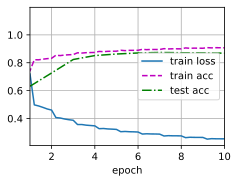

In [5]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

拉伸参数`gamma`和偏移参数`beta`

In [6]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(Tensor(shape=[6], dtype=Float32, value= [ 2.80600786e+00,  4.62932682e+00,  1.79432869e+00,  2.79423308e+00,  2.50639129e+00,  2.26208186e+00]),
 Tensor(shape=[6], dtype=Float32, value= [ 2.92221975e+00, -2.31010771e+00, -1.24783182e+00, -1.68998408e+00,  2.63152337e+00, -1.67827952e+00]))

简明实现

In [7]:
net = nn.SequentialCell([
    nn.Conv2d(1, 6, kernel_size=5, pad_mode='pad'), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5, pad_mode='pad'), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Dense(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Dense(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Dense(84, 10)])

使用相同超参数来训练模型

loss 0.256, train acc 0.906, test acc 0.872
12960.0 examples/sec


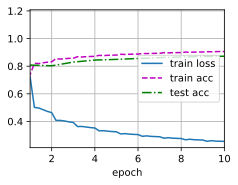

In [8]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)